# Customer Purchase Behavior Clustering
- This notebook performs clustering on customer purchase behavior data to identify distinct purchase patterns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:

purchase_behavior_features = [
    'NumDealsPurchases',  # Promo purchases
    'NumWebPurchases',  # Online
    'NumCatalogPurchases',  # Catalog
    'NumStorePurchases',  # In-store
    'NumWebVisitsMonth'  # Website visits (optional: inverse indicator)
]

df = pd.read_csv('featured_customer_segmentation.csv')
# Display the first few rows of the DataFrame
print("DataFrame Head:")
print(df.head())

DataFrame Head:
     ID  Year_Birth  Education   Income  Kidhome  Teenhome Dt_Customer  \
0  5524        1957        2.0  58138.0        0         0  2012-09-04   
1  2174        1954        2.0  46344.0        1         1  2014-03-08   
2  4141        1965        2.0  71613.0        0         0  2013-08-21   
3  6182        1984        2.0  26646.0        1         0  2014-02-10   
4  5324        1981        4.0  58293.0        1         0  2014-01-19   

   Recency  MntWines  MntFruits  ...  Store_Ratio  Catalog_Ratio  Deals_Ratio  \
0       58       635         81  ...     0.181818       0.454545     0.136364   
1       38        11          1  ...     0.500000       0.250000     0.500000   
2       26       426         49  ...     0.500000       0.100000     0.050000   
3       26        11          4  ...     0.666667       0.000000     0.333333   
4       94       173         43  ...     0.428571       0.214286     0.357143   

   Ever_Accepted_Campaign  Wine_Ratio  Fruit_Ratio  

c:\Users\DELL\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\DELL\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[11200.0, 7108.305266541399, 5115.744405090916, 4450.509295655653, 4040.849038181331, 3698.845196463856, 3458.1277928718687, 3234.7999986911213, 3015.843537850562]


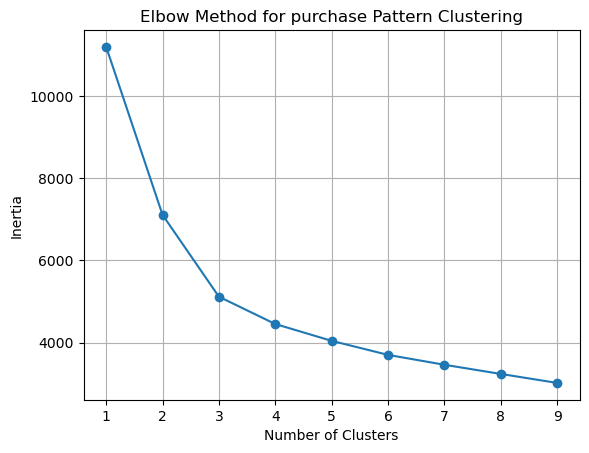

In [3]:
scaler = StandardScaler()
X_behavior = scaler.fit_transform(df[purchase_behavior_features])

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_behavior)
    inertia.append(kmeans.inertia_)

print(inertia)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for purchase Pattern Clustering')
plt.grid(True)
plt.show()


                 NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
PurchaseCluster                                                            
0                             1.84             1.99                 0.54   
1                             4.15             6.63                 2.72   
2                             1.31             5.03                 5.47   

                 NumStorePurchases  NumWebVisitsMonth  Total_Purchases  
PurchaseCluster                                                         
0                             3.16               6.40             5.68  
1                             7.28               6.56            16.64  
2                             8.36               2.82            18.86  


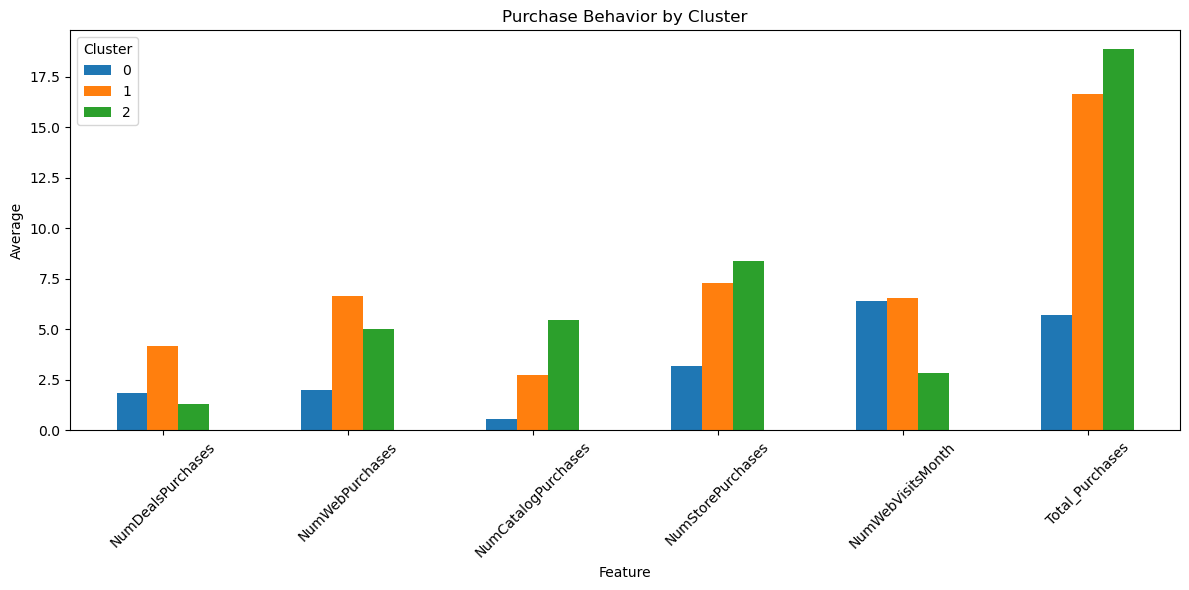

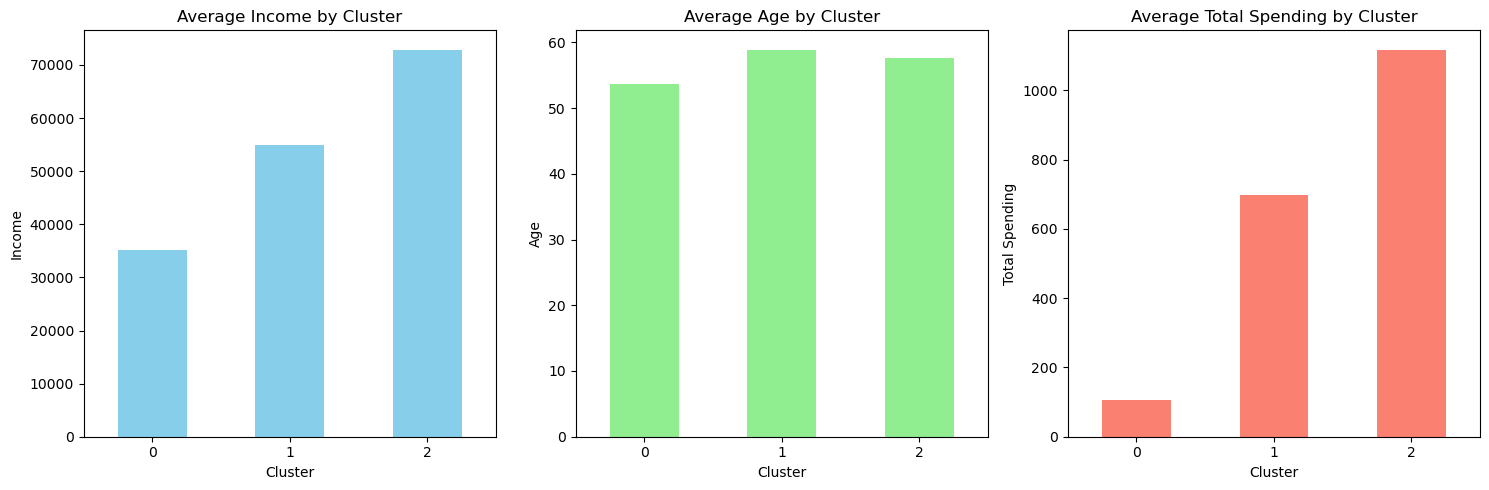

In [4]:

kmeans = KMeans(n_clusters=3, random_state=42)
df['PurchaseCluster'] = kmeans.fit_predict(X_behavior)
purchase_behavior_features = list(purchase_behavior_features) + ['Total_Purchases']
cluster_summary = df.groupby('PurchaseCluster')[purchase_behavior_features].mean().round(2)
print(cluster_summary)

cluster_summary.T.plot(kind='bar', figsize=(12, 6))
plt.title('Purchase Behavior by Cluster')
plt.ylabel('Average')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Create separate small charts for each feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Income
df.groupby('PurchaseCluster')['Income'].mean().round(2).plot(
    kind='bar', ax=axes[0], color='skyblue'
)
axes[0].set_title('Average Income by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Income')
axes[0].tick_params(rotation=0)

# Plot Age 
df.groupby('PurchaseCluster')['Age'].mean().round(2).plot(
    kind='bar', ax=axes[1], color='lightgreen'
)
axes[1].set_title('Average Age by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Age')
axes[1].tick_params(rotation=0)

# Plot Total Spending
df.groupby('PurchaseCluster')['Total_Spending'].mean().round(2).plot(
    kind='bar', ax=axes[2], color='salmon'
)
axes[2].set_title('Average Total Spending by Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Total Spending')
axes[2].tick_params(rotation=0)

plt.tight_layout()
plt.show()


DEMOGRAPHICS MEANS BY CLUSTER:
                 Education  Total_Dependents  Teenhome  Kidhome
PurchaseCluster                                                
0                     2.32              1.21      0.45     0.76
1                     2.60              1.28      0.86     0.41
2                     2.56              0.35      0.32     0.03


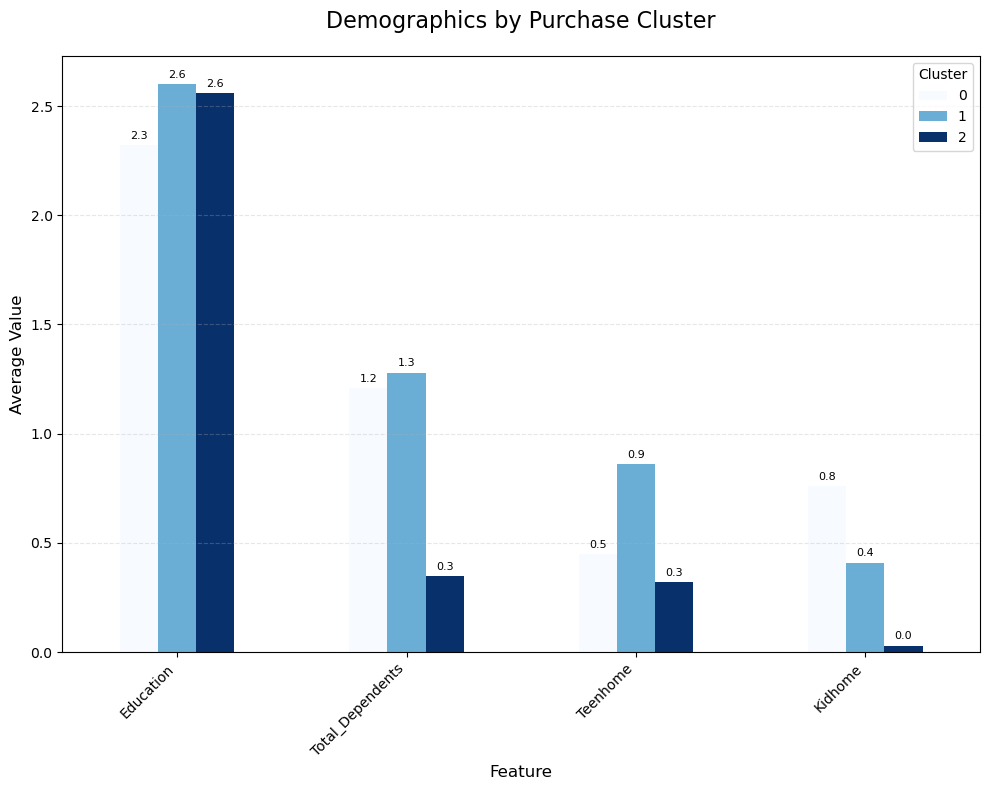


EXPENSES MEANS BY CLUSTER:
                 MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
PurchaseCluster                                                          
0                   48.22       5.21            23.63             7.62   
1                  435.65      21.35           138.26            29.08   
2                  557.33      44.92           338.01            68.59   

                 MntSweetProducts  MntGoldProds  
PurchaseCluster                                  
0                            5.10         15.81  
1                           21.31         53.04  
2                           45.92         62.47  


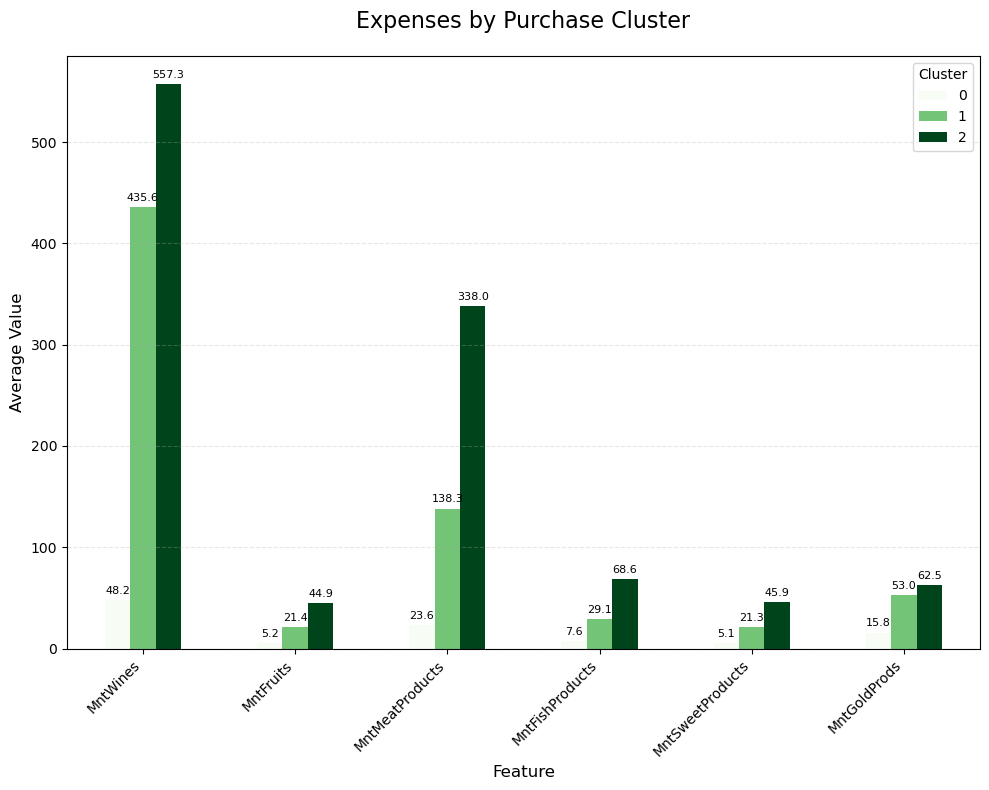


PURCHASE CHANNELS MEANS BY CLUSTER:
                 NumWebPurchases  NumStorePurchases  NumCatalogPurchases  \
PurchaseCluster                                                            
0                           1.99               3.16                 0.54   
1                           6.63               7.28                 2.72   
2                           5.03               8.36                 5.47   

                 NumDealsPurchases  NumWebVisitsMonth  
PurchaseCluster                                        
0                             1.84               6.40  
1                             4.15               6.56  
2                             1.31               2.82  


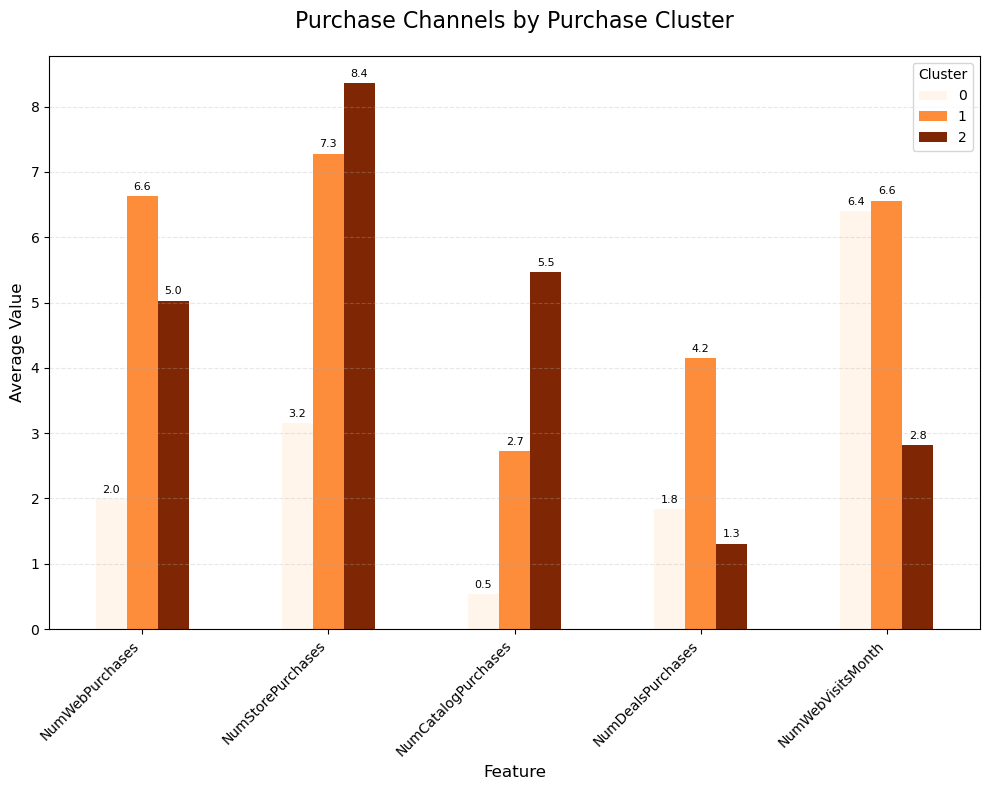


CASH MEANS BY CLUSTER:
                 Total_Spending    Income
PurchaseCluster                          
0                        105.59  35173.56
1                        698.71  54965.43
2                       1117.25  72875.24


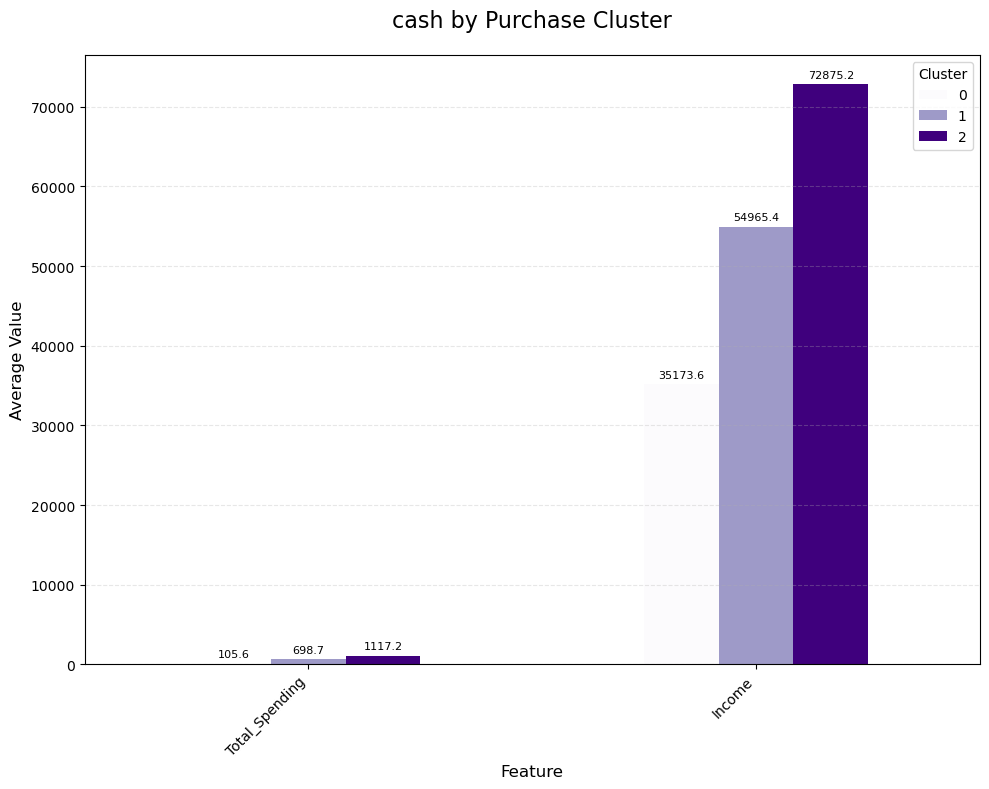


CHANNEL_RATIOS MEANS BY CLUSTER:
                 Web_Ratio  Store_Ratio  Catalog_Ratio  Deals_Ratio
PurchaseCluster                                                    
0                     0.33         0.59           0.08          inf
1                     0.40         0.44           0.16         0.28
2                     0.27         0.44           0.29         0.07


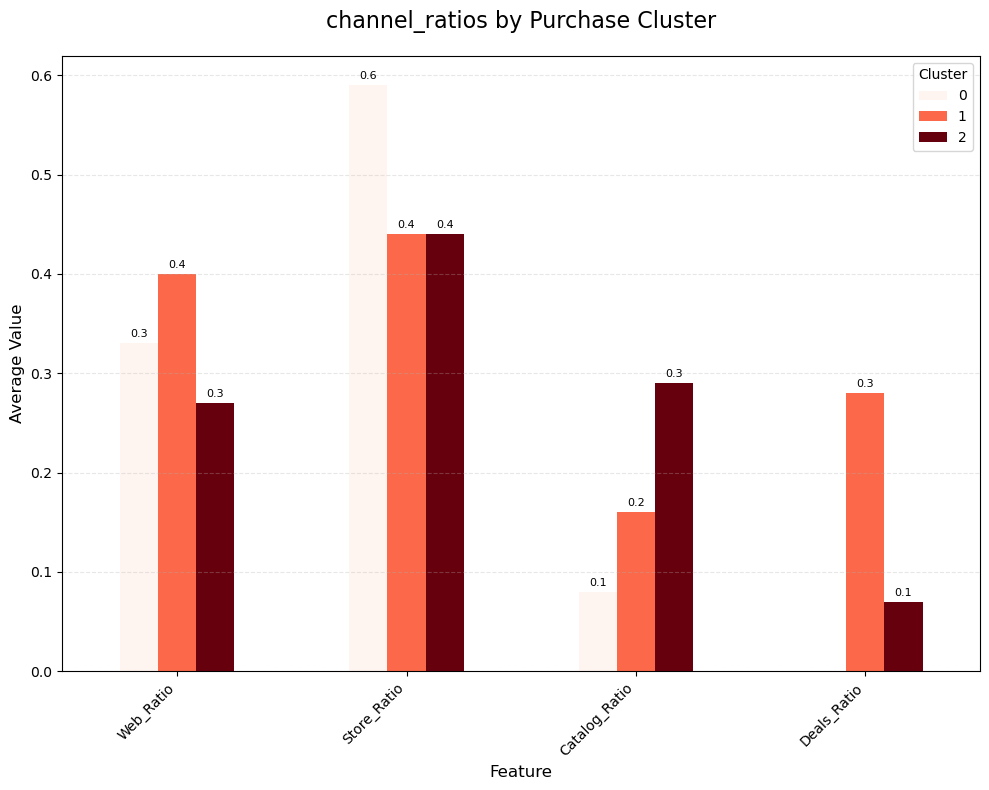


EXPENSE_RATIOS MEANS BY CLUSTER:
                 Wine_Ratio  Fruit_Ratio  Meat_Ratio  Fish_Ratio  Sweet_Ratio  \
PurchaseCluster                                                                 
0                      0.38         0.06        0.24        0.09         0.06   
1                      0.61         0.03        0.20        0.04         0.03   
2                      0.48         0.04        0.30        0.07         0.05   

                 Gold_Ratio  
PurchaseCluster              
0                      0.17  
1                      0.09  
2                      0.06  


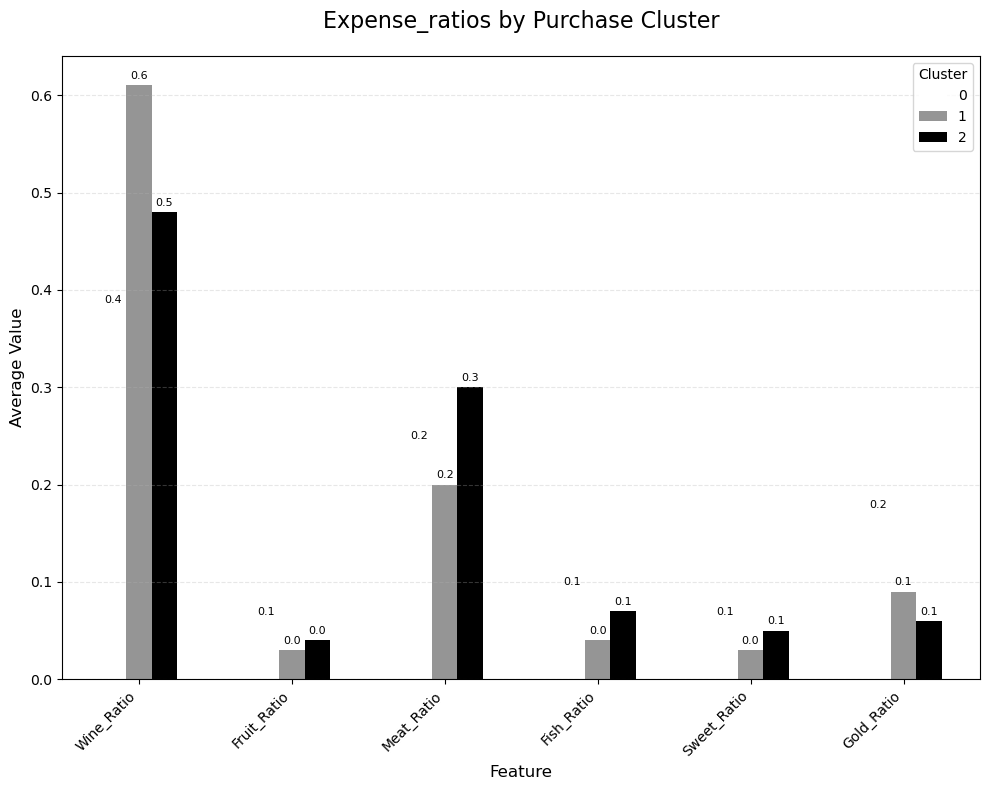

In [5]:

# Organize features by category
feature_categories = {
    'Demographics': [ 'Education', 'Total_Dependents',
                    'Teenhome', 'Kidhome'],
    'Expenses': [ 'MntWines', 'MntFruits', 'MntMeatProducts',
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'],
    'Purchase Channels': ['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases',
                         'NumDealsPurchases','NumWebVisitsMonth'],
    'cash': ['Total_Spending','Income'],
    'channel_ratios': ['Web_Ratio', 'Store_Ratio', 'Catalog_Ratio', 'Deals_Ratio'],
    'Expense_ratios': ['Wine_Ratio', 'Fruit_Ratio', 'Meat_Ratio',
                         'Fish_Ratio', 'Sweet_Ratio', 'Gold_Ratio']
}

# Color palettes for each category
color_palettes = {
     'cash': 'Purples'  ,
    'Demographics': 'Blues',

    'Purchase Channels': 'Oranges',

    'channel_ratios': 'Reds',
    'Expenses': 'Greens',
    'Expense_ratios': 'Greys'

}


# Plot each category
for category_name, features in feature_categories.items():
    # Calculate means by cluster
    cluster_means = df.groupby('PurchaseCluster')[features].mean().round(2)
    print(f"\n{category_name.upper()} MEANS BY CLUSTER:")
    print(cluster_means)

    # Create figure with appropriate size based on feature count
    fig_width = min(14, max(10, len(features)))
    fig, ax = plt.subplots(figsize=(fig_width, 8))

    # Plot the transposed data for better visualization
    cluster_means.T.plot(kind='bar', ax=ax, colormap=color_palettes[category_name])

    # Add styling
    plt.title(f'{category_name} by Purchase Cluster', fontsize=16, pad=20)
    plt.ylabel('Average Value', fontsize=12)
    plt.xlabel('Feature', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Cluster', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)

    plt.tight_layout()
    plt.show()



In [6]:
# Create radar chart comparing key metrics across clusters
# Select representative metrics from each category
key_metrics = ['Age', 'Income', 'Education', 'Total_Spending',
              'NumWebPurchases' ,'NumWebVisitsMonth''NumStorePurchases', 'NumCatalogPurchases',]

# Get data and normalize for radar chart
radar_data = df.groupby('PurchaseCluster')[key_metrics].mean()

# Normalize each metric to 0-100 scale
for col in radar_data.columns:
    radar_data[col] = 100 * radar_data[col] / radar_data[col].max()

# Set up radar chart
angles = np.linspace(0, 2*np.pi, len(key_metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each cluster
for cluster in radar_data.index:
    values = radar_data.loc[cluster].tolist()
    values += values[:1]  # Close the polygon

    ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1)

# Add labels
labels = [x.replace('_', ' ') for x in key_metrics]
labels += [labels[0]]  # Complete the circle of labels
ax.set_xticks(angles)
ax.set_xticklabels(labels)

# Customize chart
ax.set_title('Key Metrics by Purchase Cluster (Normalized)', size=16, pad=20)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

KeyError: "Columns not found: 'NumWebVisitsMonthNumStorePurchases'"

In [ ]:
from sklearn.cluster import DBSCAN


# Apply DBSCAN on the standardized purchase behavior data
# Adjust eps and min_samples based on your data
dbscan = DBSCAN(eps=1.0, min_samples=5)

# Fit DBSCAN model
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_behavior)

# Count clusters (-1 indicates noise points)
cluster_counts = df['DBSCAN_Cluster'].value_counts().sort_index()
print("DBSCAN Cluster Counts:")
print(cluster_counts)

# Calculate percentage of data points in each cluster
total_points = len(df)
cluster_percentages = (cluster_counts / total_points * 100).round(2)
print("\nDBSCAN Cluster Percentages:")
for cluster, percentage in cluster_percentages.items():
    status = "Noise points" if cluster == -1 else f"Cluster {cluster}"
    print(f"{status}: {percentage}%")

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_behavior)

# Visualize the DBSCAN clusters with PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['DBSCAN_Cluster'],
                      cmap='viridis', s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='DBSCAN Cluster')
plt.title('DBSCAN Clustering of Purchase Behavior (PCA View)', fontsize=16, pad=20)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare DBSCAN clusters with KMeans clusters
cross_tab = pd.crosstab(df['DBSCAN_Cluster'], df['PurchaseCluster'],
                        normalize='index') * 100
print("\nCross-tabulation (%) of DBSCAN vs. KMeans clusters:")
print(cross_tab.round(2))

# Compare purchase patterns across DBSCAN clusters
purchase_metrics = purchase_behavior_features + ['Total_Purchases', 'Income', 'Total_Spending']

# Get cluster summaries, handling -1 (noise) separately
cluster_summary = df.groupby('DBSCAN_Cluster')[purchase_metrics].mean().round(2)
print("\nPurchase Behavior by DBSCAN Cluster:")
print(cluster_summary)

# Visualize key metrics by DBSCAN cluster
metrics_to_plot = ['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases', 'NumDealsPurchases']

plt.figure(figsize=(14, 8))
ax = cluster_summary[metrics_to_plot].plot(kind='bar', figsize=(14, 8))
plt.title('Purchase Channel Usage by DBSCAN Cluster', fontsize=16, pad=20)
plt.xlabel('DBSCAN Cluster (-1 = Noise)')
plt.ylabel('Average Number of Purchases')
plt.legend(title='Purchase Channel')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

# Characterize the clusters based on their features
print("\nDBSCAN Cluster Characteristics:")
for cluster in sorted(df['DBSCAN_Cluster'].unique()):
    if cluster == -1:
        print("\nNoise Points:")
    else:
        print(f"\nCluster {cluster}:")

    # Get top distinctive features
    cluster_data = cluster_summary.loc[cluster]

    # For non-noise clusters, find distinguishing features
    if cluster != -1:
        other_clusters = cluster_summary.drop(cluster)


In [ ]:


# Get average ratios per cluster
channel_ratios = df.groupby('PurchaseCluster')[['Web_Ratio', 'Store_Ratio', 'Catalog_Ratio', 'Deals_Ratio']].mean()

# Create bar plot
ax = channel_ratios.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Preferred Purchase Channels by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Purchases')
plt.legend(title='Channel')
plt.xticks(rotation=0)

# Add value labels on bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

# Print favorite channel for each cluster
for cluster in range(len(channel_ratios)):
    favorite_channel = channel_ratios.iloc[cluster].idxmax()
    ratio = channel_ratios.iloc[cluster][favorite_channel]
    print(f"Cluster {cluster} favorite channel: {favorite_channel.replace('_Ratio', '')} ({ratio:.2%})")


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("SCATTER PLOT ANALYSIS FOR PURCHASE BEHAVIOR CLUSTERS")


# 1. PCA Scatter Plot - Most comprehensive view of purchase patterns
print("\n1. PCA-based Scatter Plot for Purchase Cluster Visualization")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_behavior)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['PurchaseCluster'], 
                     cmap='viridis', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Purchase Cluster')
plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Purchase Behavior Clusters (PCA View)', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)

# Add cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x', 
           s=300, linewidths=4, label='Cluster Centers')
plt.legend()
plt.tight_layout()
plt.show()

print(f"PCA explains {sum(pca.explained_variance_ratio_):.1%} of total variance in purchase behavior")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # optional for nicer aesthetics

# 1. Compute your correlations
features = [
    'Income', 'Age', 'Total_Dependents', 'Tenure_Days',
    'Teenhome', 'Kidhome', 'Education',
    'Marital_Together', 'Marital_Single', 'Marital_Divorced', 'Marital_Widow',
    'PurchaseCluster'
]
corr = df[features].corr()

# 2. Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# 3. Plot
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    square=True,
    cbar_kws={'shrink': .8, 'label': 'Pearson ρ'},
    vmin=-1, vmax=1,
    center=0,
    cmap='vlag'   # a red‑to‑blue diverging map; you could switch back to 'coolwarm' if you prefer
)

# 4. Styling
plt.title('Feature Correlation Matrix (Lower Triangle)', fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# 5. Interpretation legend
plt.gcf().text(
    0.01, 0.01,
    "■ Strong positive (> 0.7)\n■ Strong negative (< -0.7)\n■ Near zero: weak/no linear relation",
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.show()

print(correlation_matrix)
